<a href="https://colab.research.google.com/github/asdevika2001/COGNORISE/blob/main/house_price_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import Needed Libraries**

In [1]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from scipy import stats

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from category_encoders import MEstimateEncoder

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# **EDA and Preprocessing**

In [3]:
df = pd.read_csv('data.csv')

In [4]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,313000.0,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2384000.0,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,342000.0,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,550000.0,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4600 entries, 0 to 4599
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           4600 non-null   object 
 1   price          4600 non-null   float64
 2   bedrooms       4600 non-null   float64
 3   bathrooms      4600 non-null   float64
 4   sqft_living    4600 non-null   int64  
 5   sqft_lot       4600 non-null   int64  
 6   floors         4600 non-null   float64
 7   waterfront     4600 non-null   int64  
 8   view           4600 non-null   int64  
 9   condition      4600 non-null   int64  
 10  sqft_above     4600 non-null   int64  
 11  sqft_basement  4600 non-null   int64  
 12  yr_built       4600 non-null   int64  
 13  yr_renovated   4600 non-null   int64  
 14  street         4600 non-null   object 
 15  city           4600 non-null   object 
 16  statezip       4600 non-null   object 
 17  country        4600 non-null   object 
dtypes: float

**Let's plot some graph to get the idea which features dominate our target.**

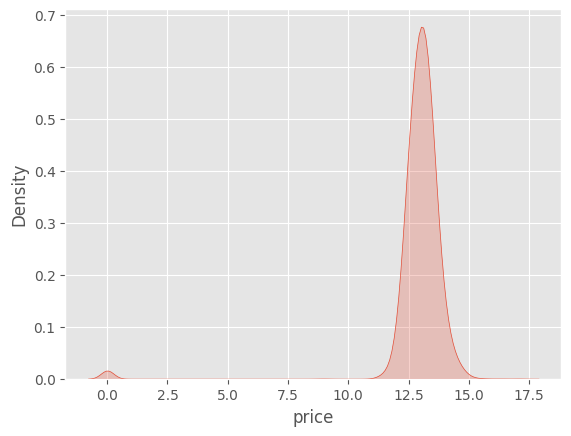

In [6]:
sns.kdeplot(df['price'].apply(np.log1p), fill=True)
plt.show()

In [7]:
def make_mi_score(x,y):
    x = x.copy()
    for colname in x.select_dtypes(['object','category']):
        x[colname], _ = x[colname].factorize()

    discrete_features = [pd.api.types.is_integer_dtype(t) for t in x.dtypes]
    mi_score = mutual_info_regression(x, y, discrete_features=discrete_features, random_state=42)
    mi_score = pd.Series(mi_score, name='Mutual Information Score', index=x.columns)
    mi_score = mi_score.sort_values(ascending=False)
    return mi_score

In [8]:
X = df.drop(columns=['price'])
y = df[['price']]

mi_score = make_mi_score(X, y)
mi_score

street           1.187259
statezip         0.453802
city             0.315389
sqft_living      0.298434
sqft_above       0.200396
bathrooms        0.184815
sqft_lot         0.145104
bedrooms         0.080524
yr_built         0.075527
floors           0.053934
view             0.050866
sqft_basement    0.046252
yr_renovated     0.011067
waterfront       0.005997
date             0.005088
condition        0.001126
country          0.000000
Name: Mutual Information Score, dtype: float64

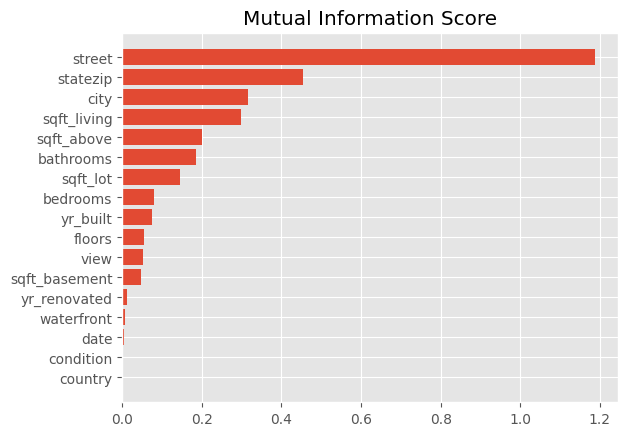

In [9]:
def plot_mi_score(score):
    score = score.sort_values(ascending = True)
    width = np.arange(len(score))
    ticks = list(score.index)
    plt.barh(width,score)
    plt.yticks(width,ticks)
    plt.title('Mutual Information Score')

plot_mi_score(mi_score)

In [10]:
df = df[['street','statezip','city','sqft_living','sqft_above','bathrooms','yr_built','sqft_lot','bedrooms']]

In [11]:
df

,street,statezip,city,sqft_living,sqft_above,bathrooms,yr_built,sqft_lot,bedrooms
0,18810 Densmore Ave N,WA 98133,Shoreline,1340,1340,1.50,1955,7912,3.0
1,709 W Blaine St,WA 98119,Seattle,3650,3370,2.50,1921,9050,5.0
2,26206-26214 143rd Ave SE,WA 98042,Kent,1930,1930,2.00,1966,11947,3.0
3,857 170th Pl NE,WA 98008,Bellevue,2000,1000,2.25,1963,8030,3.0
4,9105 170th Ave NE,WA 98052,Redmond,1940,1140,2.50,1976,10500,4.0
...,...,...,...,...,...,...,...,...,...
4595,501 N 143rd St,WA 98133,Seattle,1510,1510,1.75,1954,6360,3.0
4596,14855 SE 10th Pl,WA 98007,Bellevue,1460,1460,2.50,1983,7573,3.0
4597,759 Ilwaco Pl NE,WA 98059,Renton,3010,3010,2.50,2009,7014,3.0
4598,5148 S Creston St,WA 98178,Seattle,2090,1070,2.00,1974,6630,4.0


In [12]:
df = df.join(y)

In [13]:
z = np.abs(stats.zscore(df[['sqft_living','sqft_above','bathrooms','yr_built','sqft_lot','bedrooms']]))
print(z)

      sqft_living  sqft_above  bathrooms  yr_built  sqft_lot  bedrooms
0        0.829971    0.565224   0.843204  0.531014  0.193434  0.441122
1        1.568528    1.789559   0.432802  1.674693  0.161718  1.759705
2        0.217367    0.119171   0.205201  0.161000  0.080978  0.441122
3        0.144686    0.959621   0.113800  0.261913  0.190145  0.441122
4        0.206984    0.797222   0.432802  0.175376  0.121306  0.659291
...           ...         ...        ...       ...       ...       ...
4595     0.653458    0.368025   0.524202  0.564651  0.236689  0.441122
4596     0.705374    0.426025   0.432802  0.410840  0.202882  0.441122
4597     0.904009    1.371962   0.432802  1.285418  0.218462  0.441122
4598     0.051238    0.878421   0.205201  0.108101  0.229164  0.659291
4599     0.674224    0.391225   0.432802  0.646303  0.188139  0.441122

[4600 rows x 6 columns]


In [14]:
threshold = 3
print(np.where(z > 3))

(array([  56,  107,  122,  122,  122,  122,  122,  217,  227,  233,  240,
        241,  252,  252,  252,  254,  272,  291,  291,  375,  418,  418,
        452,  461,  462,  462,  462,  462,  471,  479,  484,  495,  548,
        575,  581,  581,  634,  634,  634,  675,  679,  743,  747,  779,
        798,  839,  847,  878,  879,  999, 1017, 1031, 1078, 1089, 1103,
       1128, 1130, 1132, 1132, 1182, 1182, 1209, 1209, 1209, 1261, 1265,
       1272, 1275, 1275, 1301, 1302, 1302, 1360, 1390, 1406, 1408, 1411,
       1417, 1417, 1424, 1455, 1479, 1500, 1539, 1567, 1567, 1571, 1602,
       1637, 1644, 1722, 1762, 1786, 1944, 1952, 1952, 1962, 1962, 2005,
       2005, 2152, 2155, 2157, 2199, 2226, 2279, 2286, 2286, 2300, 2316,
       2328, 2328, 2328, 2365, 2401, 2480, 2551, 2588, 2654, 2654, 2654,
       2717, 2725, 2731, 2731, 2731, 2731, 2761, 2761, 2846, 2846, 2855,
       2872, 2889, 2917, 2967, 2967, 2967, 2968, 2980, 2980, 3004, 3004,
       3004, 3004, 3046, 3056, 3099, 3117, 3122, 3

In [15]:
df = df[(z < 3).all(axis=1)]

In [16]:
df.shape

(4435, 10)

In [17]:
df.head()

,street,statezip,city,sqft_living,sqft_above,bathrooms,yr_built,sqft_lot,bedrooms,price
0,18810 Densmore Ave N,WA 98133,Shoreline,1340,1340,1.50,1955,7912,3.0,313000.0
1,709 W Blaine St,WA 98119,Seattle,3650,3370,2.50,1921,9050,5.0,2384000.0
2,26206-26214 143rd Ave SE,WA 98042,Kent,1930,1930,2.00,1966,11947,3.0,342000.0
3,857 170th Pl NE,WA 98008,Bellevue,2000,1000,2.25,1963,8030,3.0,420000.0
4,9105 170th Ave NE,WA 98052,Redmond,1940,1140,2.50,1976,10500,4.0,550000.0


In [18]:
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [19]:
encoder = MEstimateEncoder(cols=['street','statezip','city'], m=0.5)
X = encoder.fit_transform(X, y)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=42)

In [21]:
model = LinearRegression()

In [22]:
model.fit(X_train, y_train)

LinearRegression()

In [23]:
model.score(X_train, y_train)

0.9985749282842019

In [24]:
model.score(X_test, y_test)

0.9995148416705144

In [25]:
from sklearn.model_selection import cross_val_score

cvs = cross_val_score(model, X_train, y_train, cv=10, n_jobs=-1)
print('Accuracy: {:.2f} %'.format(cvs.mean() * 100))

Accuracy: 99.70 %


In [26]:

y_pred = model.predict(X_test)

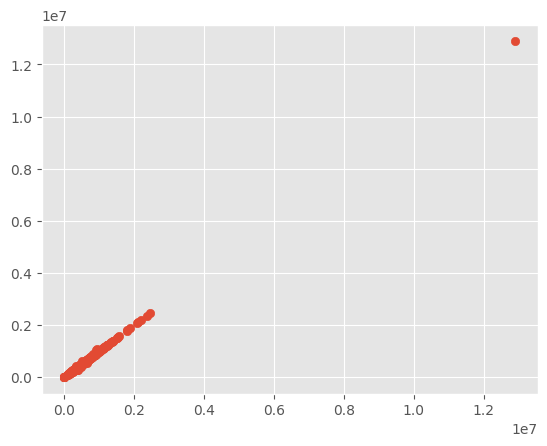

In [27]:
plt.scatter(y_test,y_pred)
plt.show()